In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39031/status,
Dashboard: /proxy/39031/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46663,Workers: 4
Dashboard: /proxy/39031/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.5:40511,Total threads: 4
Dashboard: /proxy/45819/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34983,


In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_param_kpp_extended2.db'
session_old = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session_new = cc.database.create_session(db)

expt = ['025deg_jra55_ryf_param_kpp_extended2', '025deg_jra55_ryf_control']
session = [session_old, session_new]

In [5]:
start_time = '2000-01-01'
end_time = '2199-12-31'

st = ['2090-01-01', '2162-01-01']
et = ['2099-12-31', '2171-12-31']

In [6]:
ncoarse = 12

x_min = [-100, -250, -70, -220, -70, -250]
x_max = [ 10 , -100,  20, -80 ,  20, -80 ]
y_min = [ 20 ,  20 , -42 ,-37 , -80, -80 ]
y_max = [ 75 ,  75 , -20, -20 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP', 'WG', 'RG']

## KPP Depth

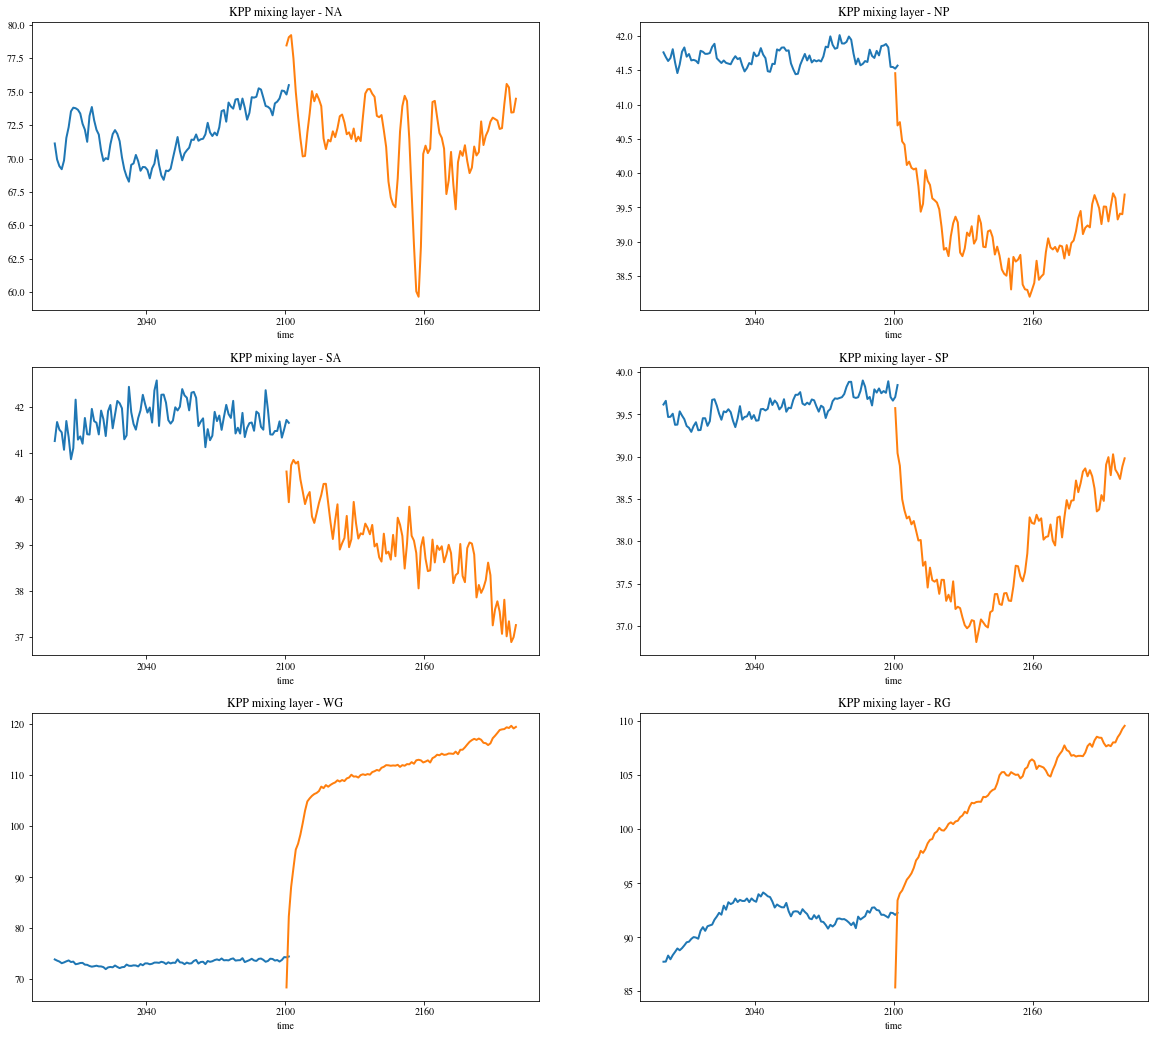

In [7]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))


for i, j in enumerate(session):
    hblt = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'hblt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hblt)

    for k, l in enumerate(basin):
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = session[i], frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')

        hblt_basin = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hblt_basin = hblt_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hblt_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)])
        del area_t

        axes[int(k/2)][int(k%2)].set_title('KPP mixing layer - ' + basin[k])

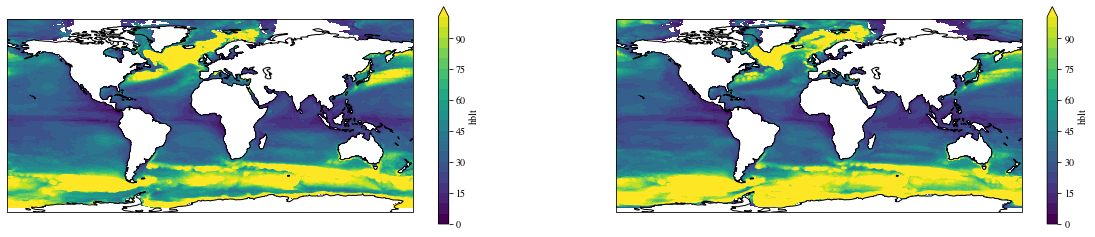

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    hblt = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'hblt', frequency = '1 monthly').sel(time = slice(st[i], et[i]))
    hblt.mean('time').plot.contourf(ax = axes[i], levels = np.linspace(0, 100, 21), transform=ccrs.PlateCarree())
    axes[i].coastlines()

## Surface temperature

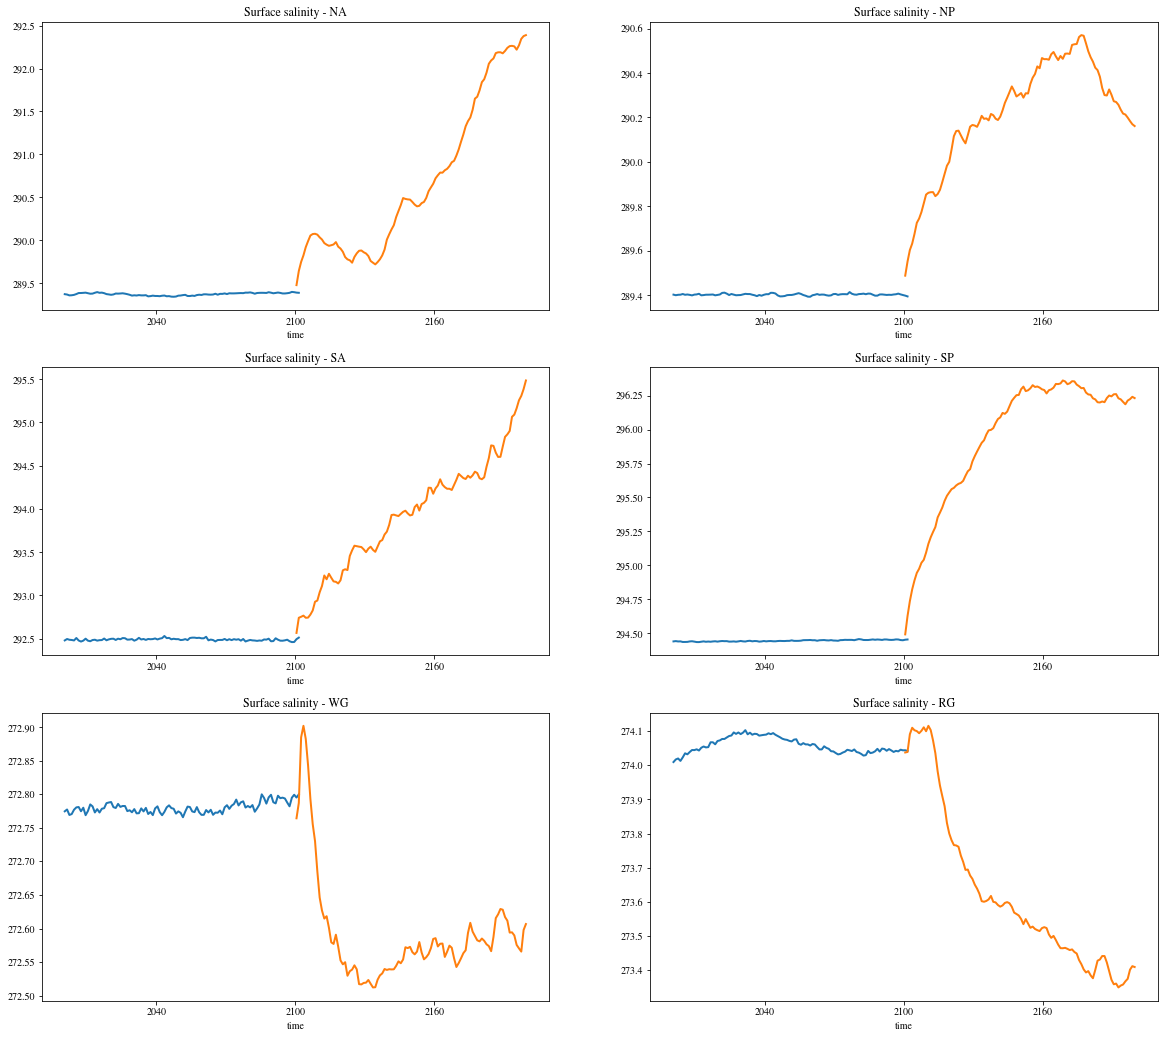

In [9]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

for i, j in enumerate(session):
    
    temp_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'temp', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    temp_sfc = temp_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(temp_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        temp_sfc_basin = (temp_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        temp_sfc_basin = temp_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        temp_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)])
        del area_t
        
        axes[int(k/2)][int(k%2)].set_title('Surface salinity - ' + basin[k])

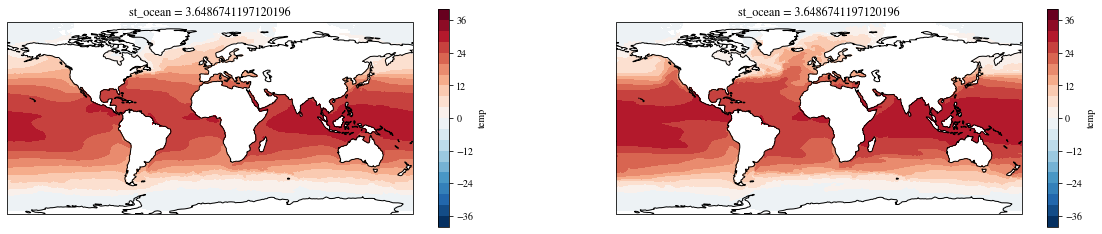

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    temp_sfc = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'temp', frequency = '1 monthly').sel(time = slice(st[i], et[i]))
    temp_sfc = temp_sfc.isel(st_ocean = 1) - 273.15
    temp_sfc.mean('time').plot.contourf(ax = axes[i], levels = np.linspace(-40, 40, 21), transform=ccrs.PlateCarree())
    axes[i].coastlines()

## Surface salinity

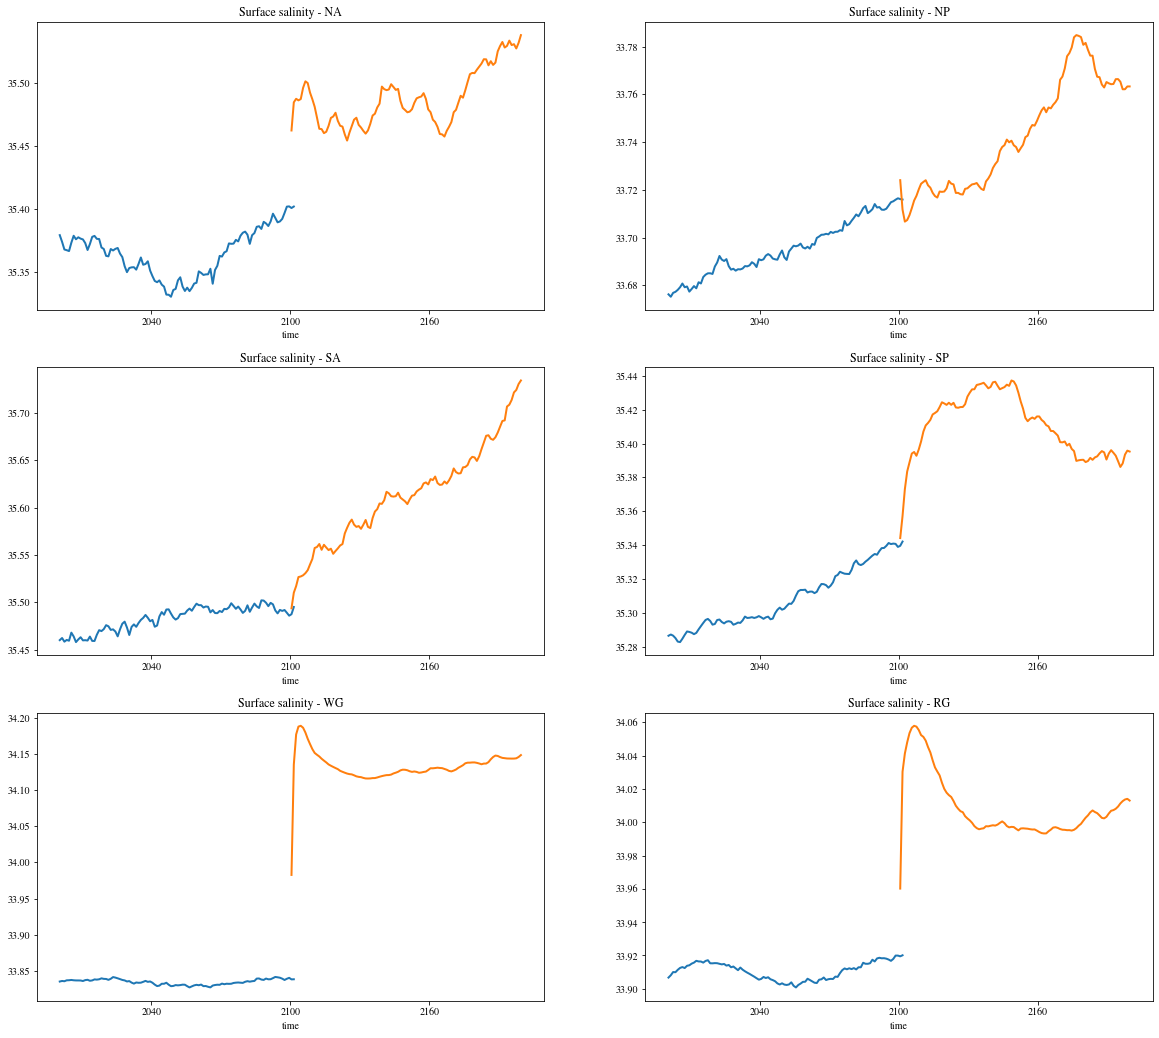

In [7]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

for i, j in enumerate(session):
    
    salt_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'salt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    salt_sfc = salt_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(salt_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        salt_sfc_basin = (salt_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        salt_sfc_basin = salt_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        salt_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)])
        del area_t
        
        axes[int(k/2)][int(k%2)].set_title('Surface salinity - ' + basin[k])

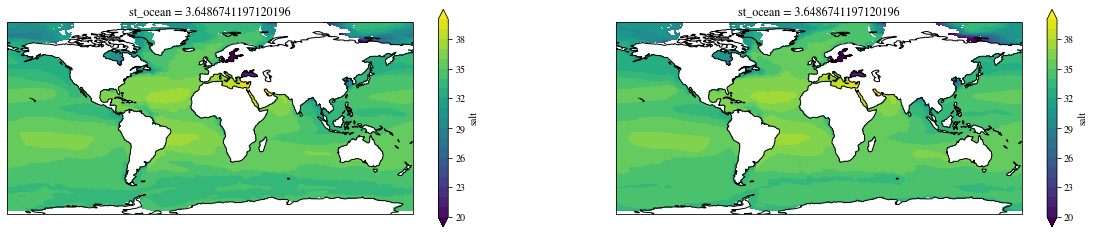

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    salt_sfc = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'salt', frequency = '1 monthly').sel(time = slice(st[i], et[i]))
    salt_sfc = salt_sfc.isel(st_ocean = 1)
    salt_sfc.mean('time').plot.contourf(ax = axes[i], levels = np.linspace(20, 40, 21), transform=ccrs.PlateCarree())
    axes[i].coastlines()

## Surface heat flux

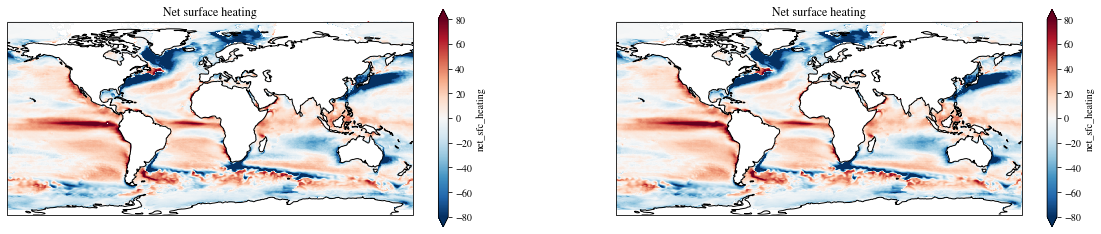

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    
    heat = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'net_sfc_heating', frequency = '1 monthly').sel(time = slice(
        st[i], et[i]))
    
    heat.mean('time').plot(ax = axes[i], vmin = -80, vmax = 80, cmap = 'RdBu_r', transform=ccrs.PlateCarree())
    axes[i].coastlines()
    axes[i].set_title('Net surface heating')

## Global diagnostics

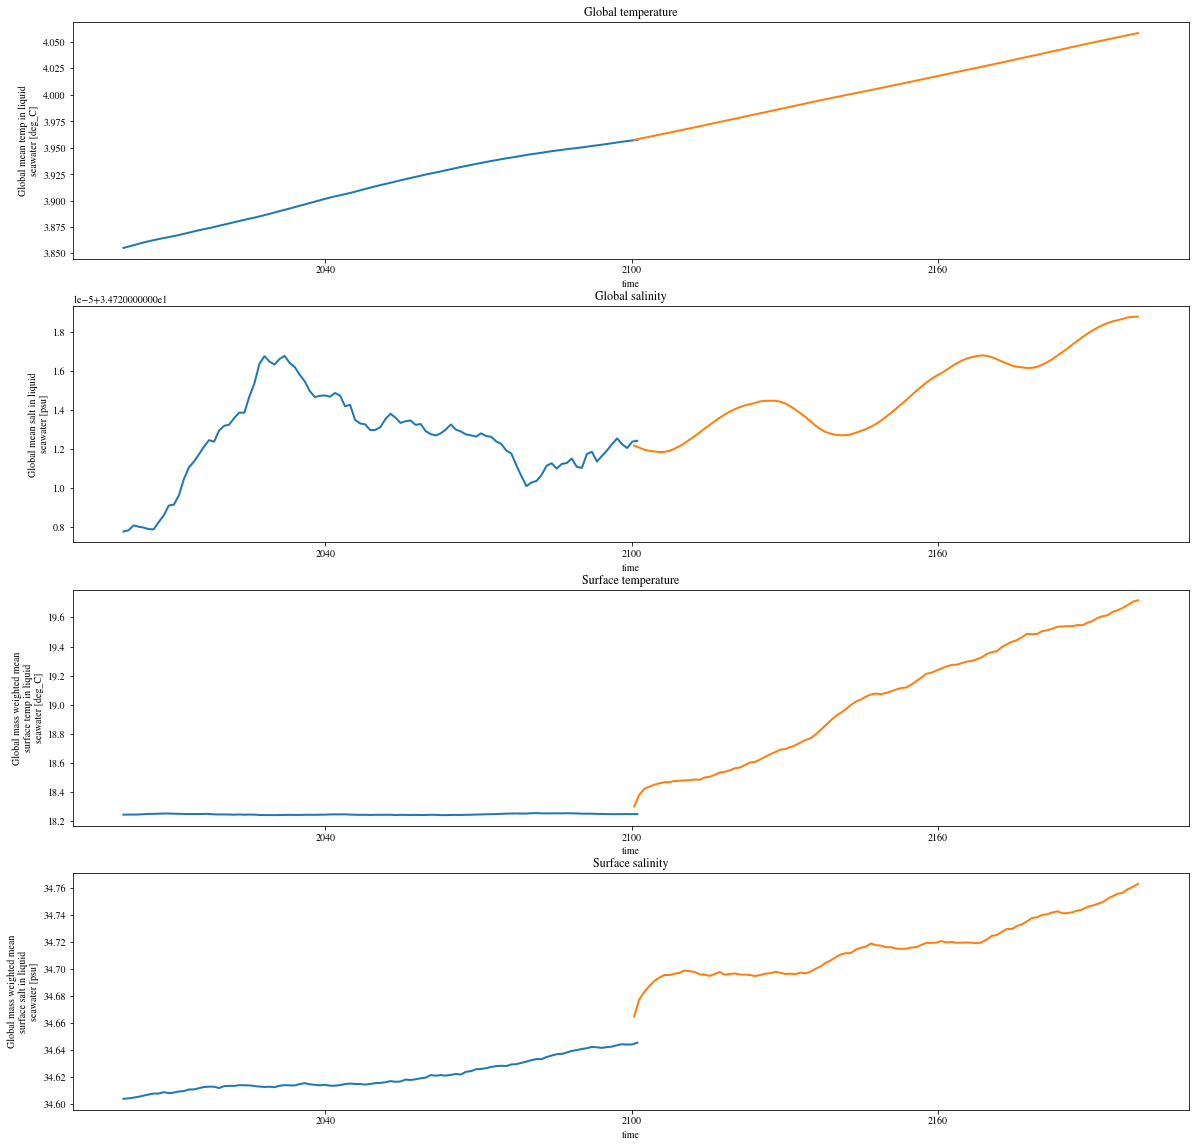

In [10]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 4, figsize = (20, 20))

var_list = ['temp_global_ave',    'salt_global_ave', 'temp_surface_ave',    'salt_surface_ave']
var_name = ['Global temperature', 'Global salinity', 'Surface temperature', 'Surface salinity']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l)#.sel(time = slice('2000-01-01'))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k])
        axes[k].set_title(var_name[k])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


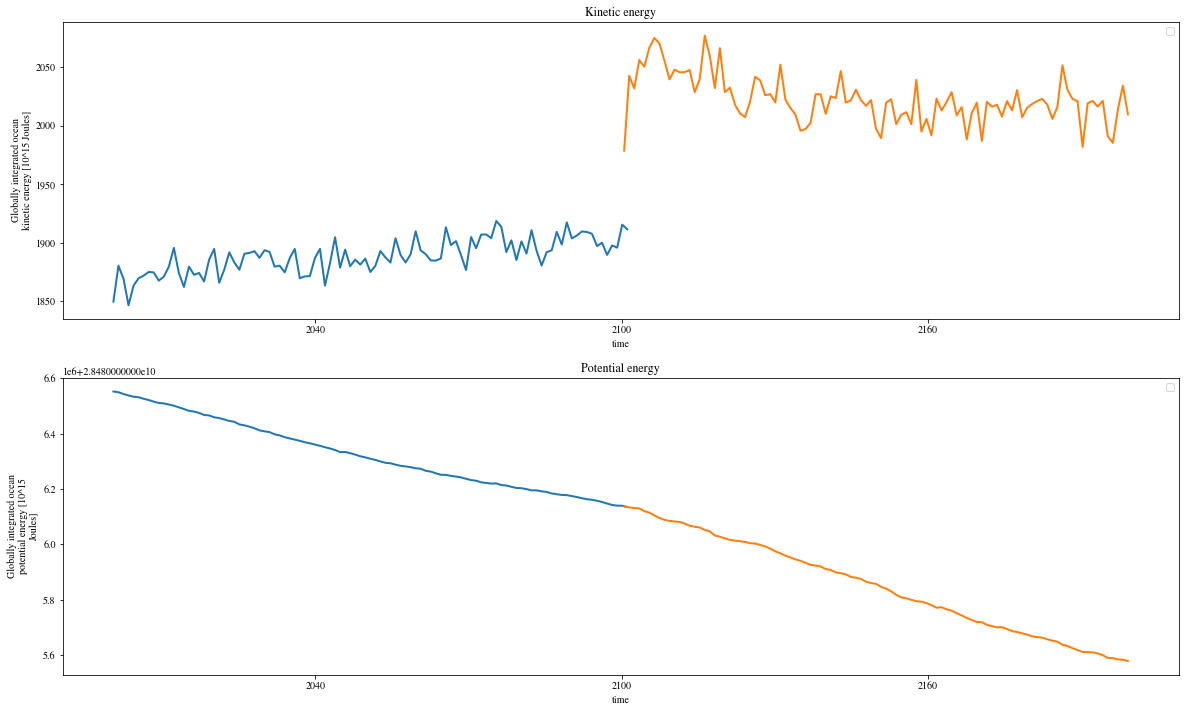

In [12]:
fig, axes = plt.subplots(nrows = 2, figsize = (20, 12))

var_list = ['ke_tot',         'pe_tot'          ]
var_name = ['Kinetic energy', 'Potential energy']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l)#.sel(time = slice('2000-01-01'))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k])
        axes[k].set_title(var_name[k])

## Circulation metrics

### ACC Transport

Text(0.5, 1.0, 'Drake Passage Transport')

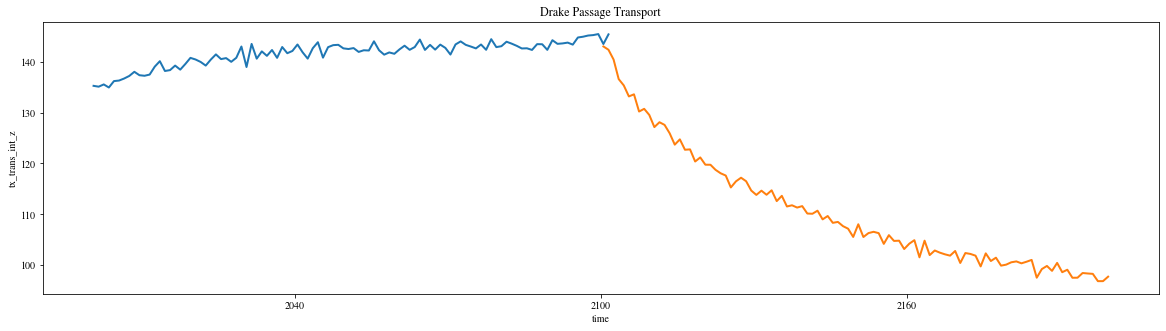

In [13]:
xmin = -69.9
ymin = -71.6
ymax = -51.0
rho0 = 1036

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j, start_time = '1900-01-01').sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    DP_trans.plot()

plt.title('Drake Passage Transport')

### AABW Circulation

Text(0.5, 1.0, 'AABW Circulation')

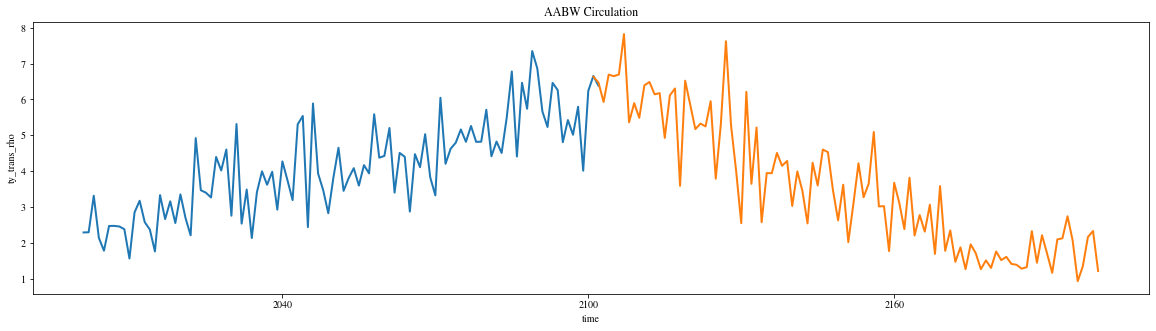

In [14]:
latitude = -45

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_aabw = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1900-01-01').sum(
        'grid_xt_ocean').sel(method = 'nearest', grid_yu_ocean = latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho = slice(1036.2, None)).min('potrho').resample(time = 'Y').mean()
    psi_aabw_sum.plot()

plt.title('AABW Circulation')

Text(0.5, 1.0, 'AMOC cell')

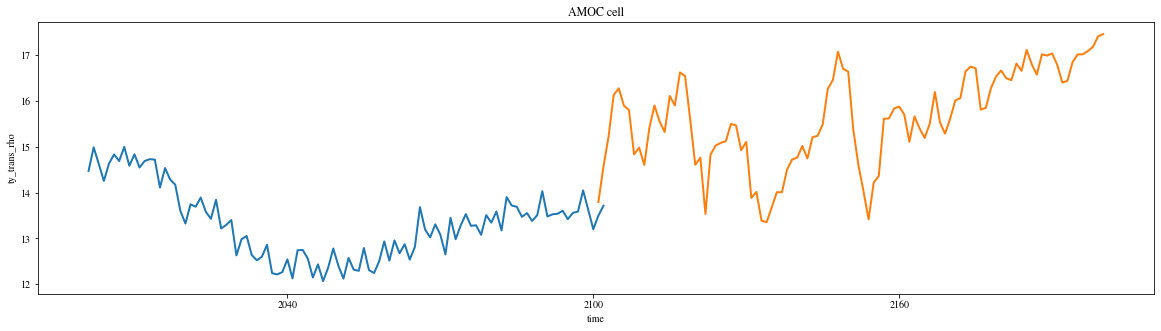

In [15]:
plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1900-01-01').sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot()

plt.title('AMOC cell')

### Gulf stream transport

Text(0.5, 1.0, 'Gulf stream WBC')

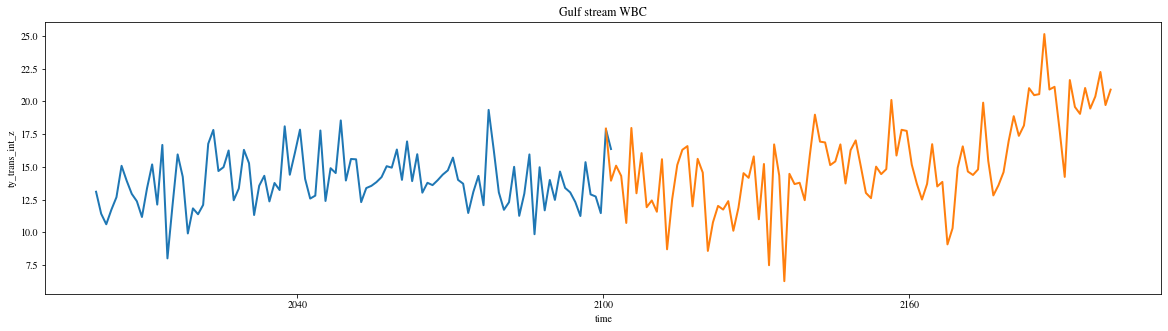

In [16]:
xmin = -85
xmax = -75
ymin = 30
rho = 1030

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    GS = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j, start_time = '1900-01-01').sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    GS = GS.coarsen({"time": ncoarse}, boundary = "trim").mean()
    GS.plot()

plt.title('Gulf stream WBC')

### Kuroshio current

Text(0.5, 1.0, 'Kuroshio current WBC')

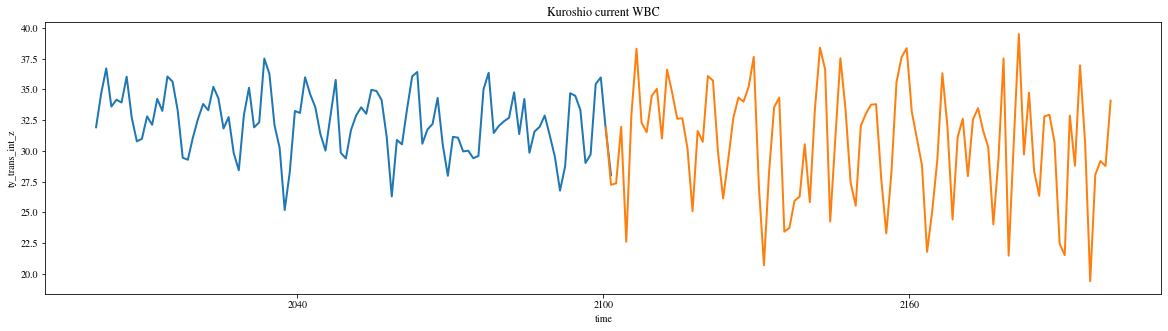

In [17]:
xmin = -250
xmax = -210
ymin = 30
rho = 1030

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    KC = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j, start_time = '1900-01-01').sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    KC = KC.coarsen({"time": ncoarse}, boundary = "trim").mean()
    KC.plot()
    
plt.title('Kuroshio current WBC')